# Panjaya - Home task by Ortal

## Introduction

Input - The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset - but just the audio data, the speech (not the song) utterances, the normal level of emotional intensity, and a single sentence.

Output - Model that spans an emotion embedding space, using audio data.

### ----------------------------------------------------------- Data Preparation ----------------------------------------------------------------------

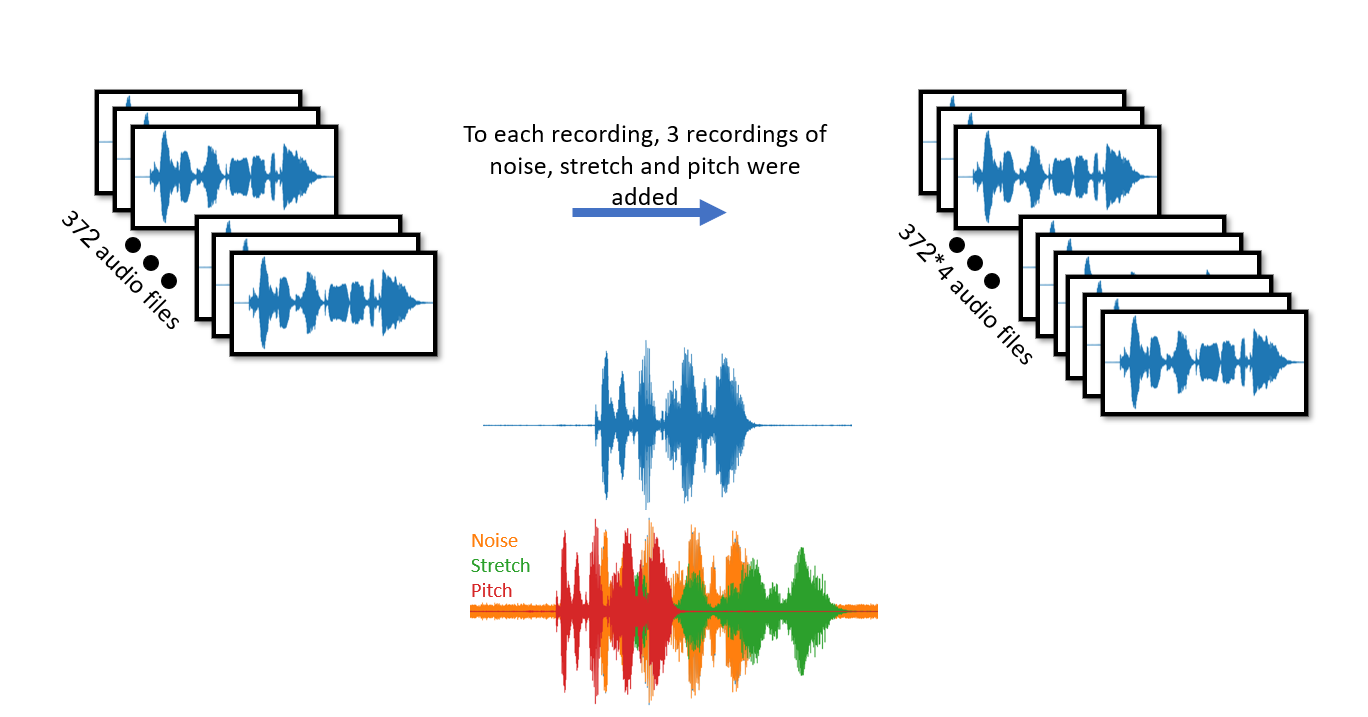

### -------------------------------------------------------- Data - Feature Extraction ----------------------------------------------------------------

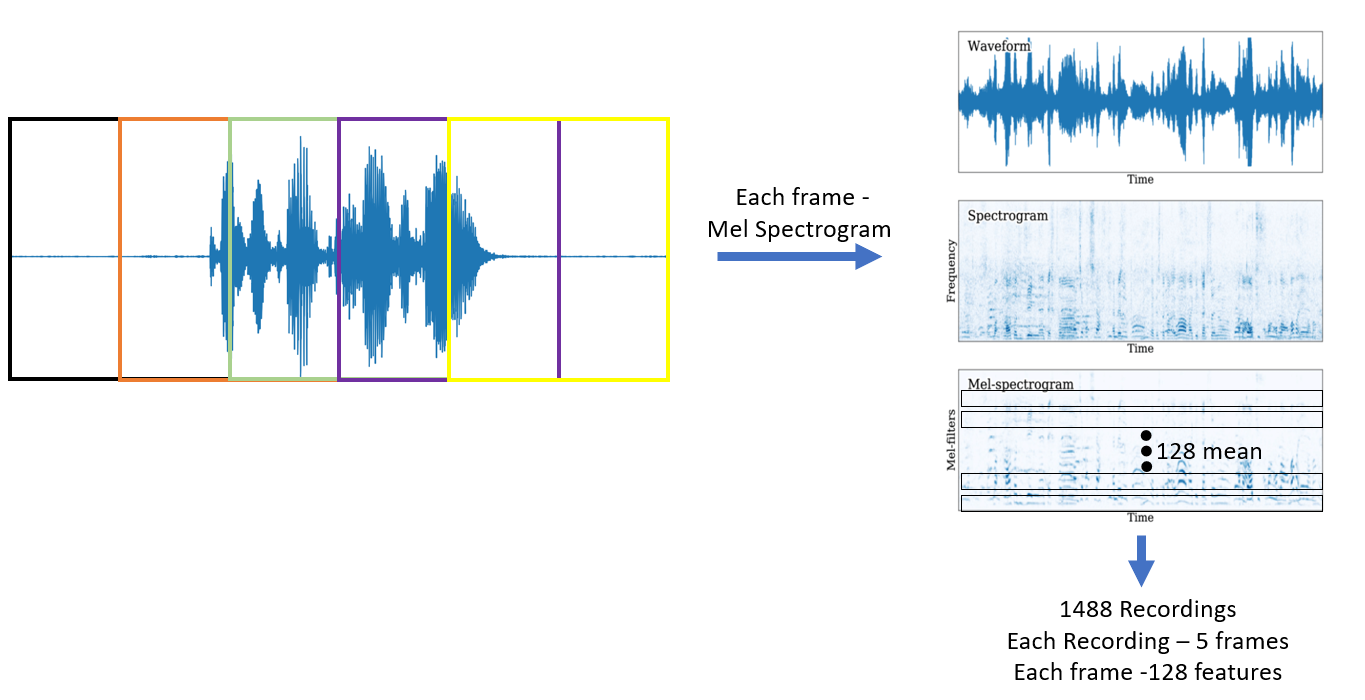

### --------------------------------------------------------- Data Preprocessing --------------------------------------------------------------------

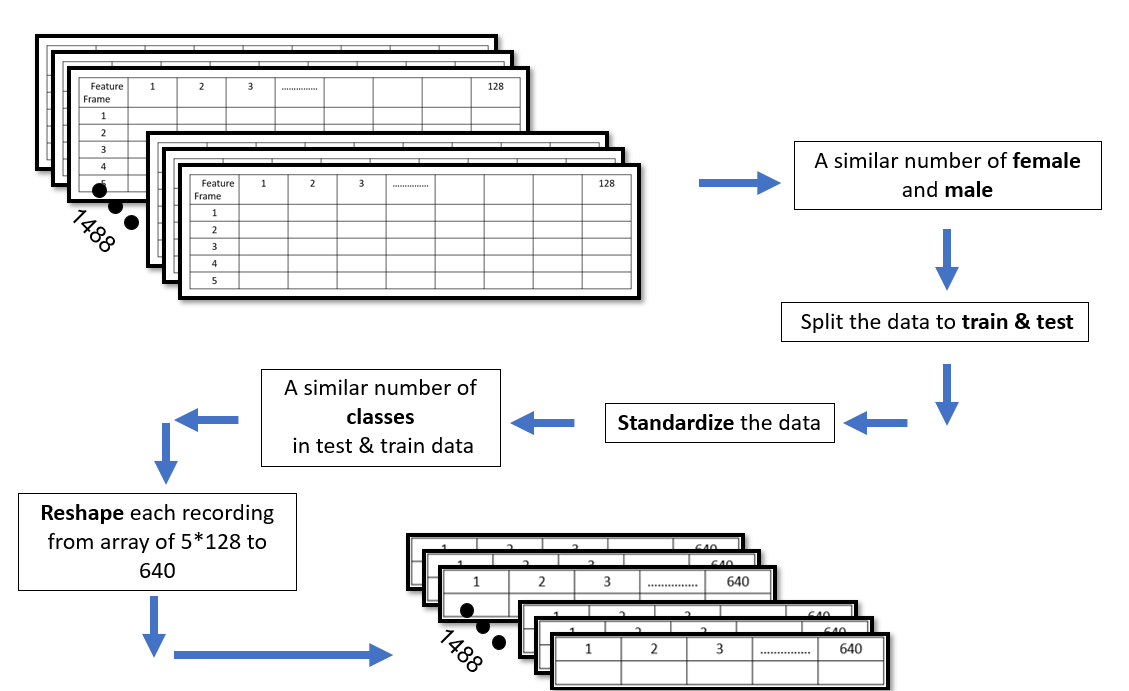

### --------------------------------------------------- Input data to siamese-networks ------------------------------------------------------------

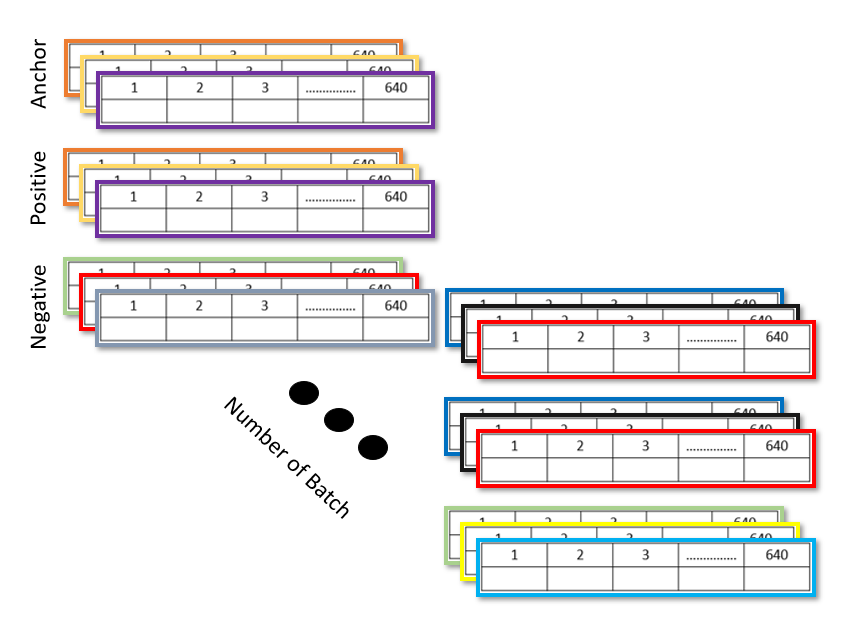

### ------------------------------------------ One step in epoch of train - siamese-networks ------------------------------------------------


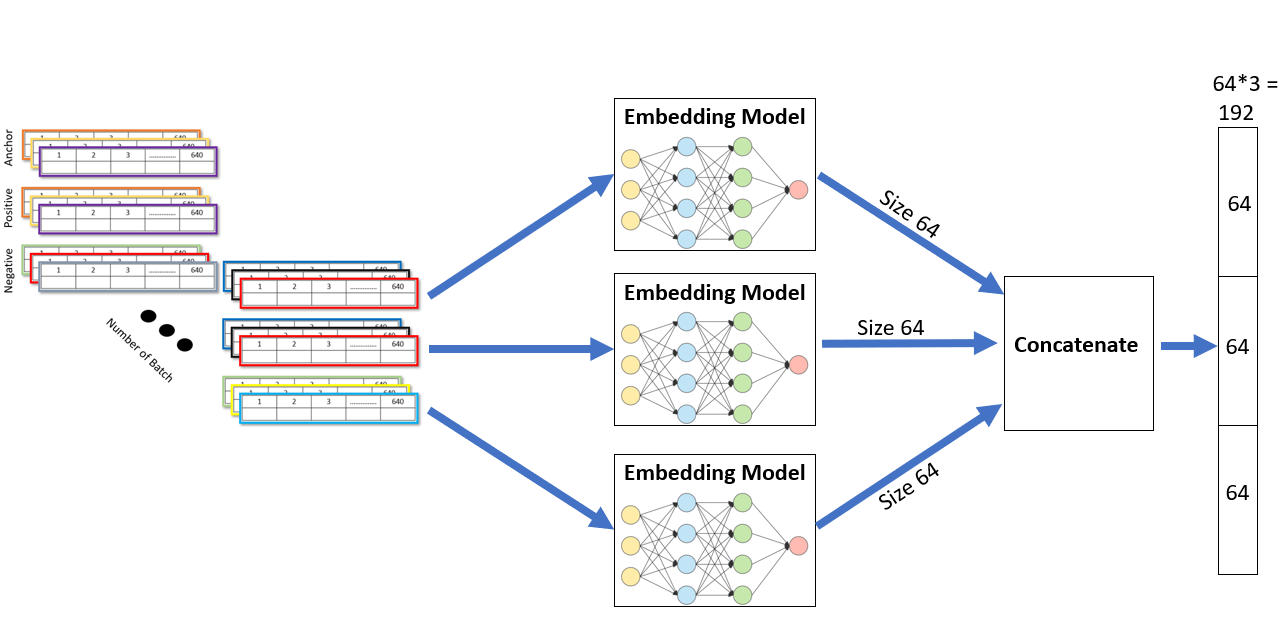

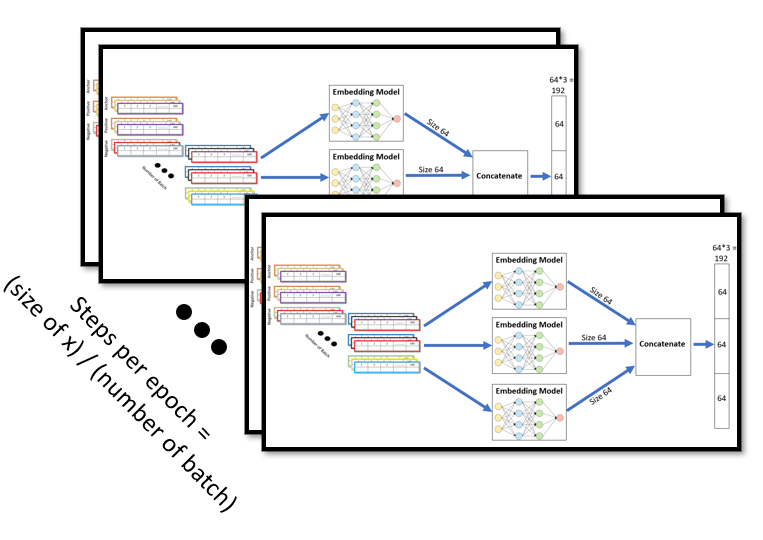

### --------------------------------------------------------- Train - siamese-networks ---------------------------------------------------------------

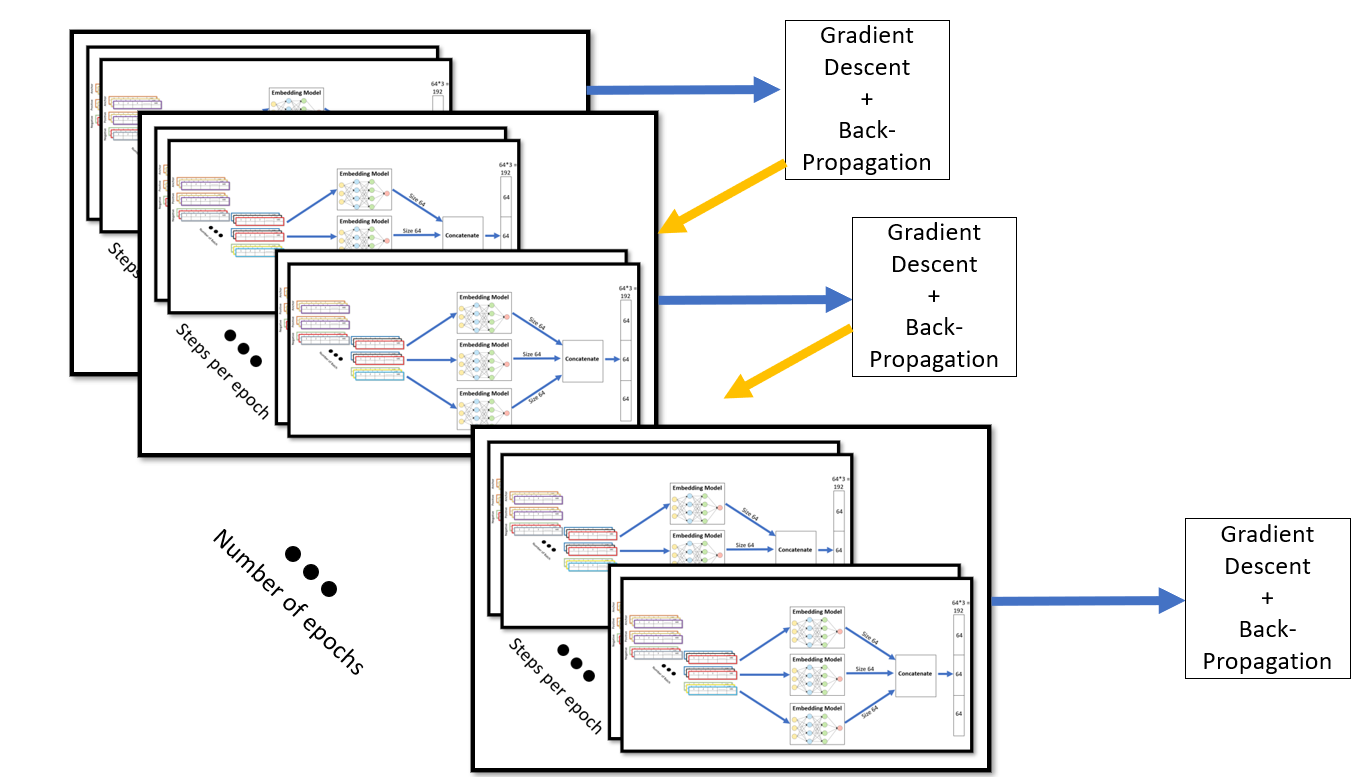

### -------------------------------------------------- Test - siamese-networks + Visualizaion----------------------------------------------------

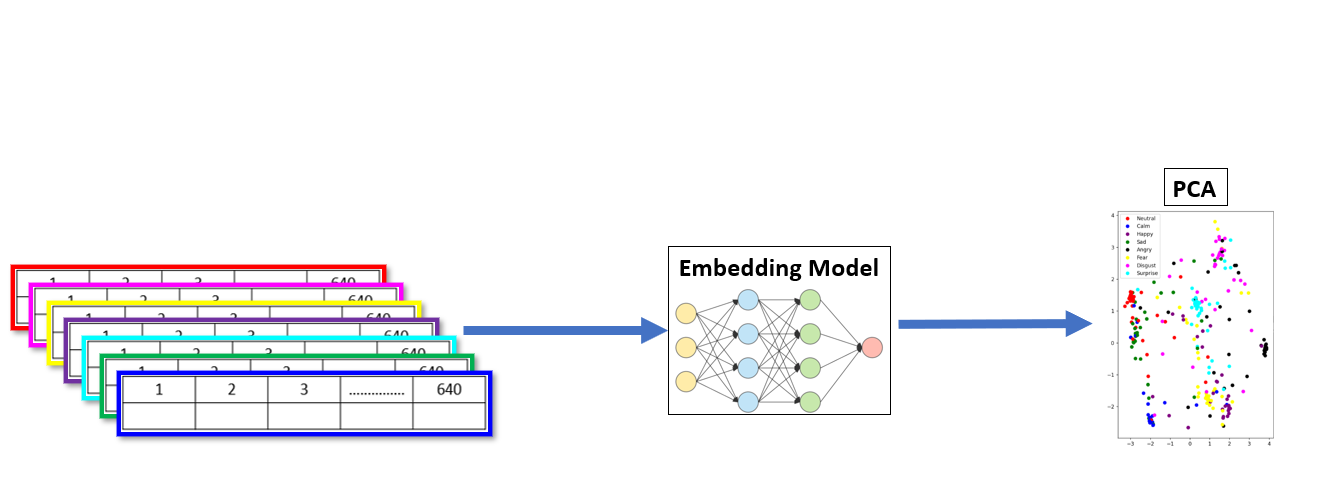

# Import Libraries

In [1]:
# General
import numpy as np
import pandas as pd

# Audio
import os
import sys
import librosa
import librosa.display
import seaborn as sns
from IPython.display import Audio

# NN
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Dinamic Plot
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Image
from IPython.display import Image

# Data Preparation

### Create a data frame with the audio clips paths & emotions

In [2]:
Ravdess = "C:/Users/gideo/OneDrive/Desktop/dataset"
ravdess_directory_list = os.listdir(Ravdess)
ravdess_directory_list = ravdess_directory_list[1:]

file_emotion = []
file_path = []
file_gender = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + '/'  +dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + '/' + dir + '/' + file)
        if ((int(part[6])) % 2) == 0:
            file_gender.append('female')
        else:
            file_gender.append('male')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# When ({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

path_df = pd.DataFrame(file_path, columns=['Path'])

Gender_df = pd.DataFrame(file_gender, columns=['Gender'])

Ravdess_df = pd.concat([emotion_df, path_df,Gender_df], axis=1)

data_path = Ravdess_df
data_path

,Emotions,Path,Gender
0,1,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,male
1,1,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,male
2,2,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,male
3,3,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,male
4,3,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,male
...,...,...,...
367,6,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,female
368,7,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,female
369,7,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,female
370,8,C:/Users/gideo/OneDrive/Desktop/dataset/Actor_...,female


### Data Exploration

In [3]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

<IPython.core.display.Javascript object>


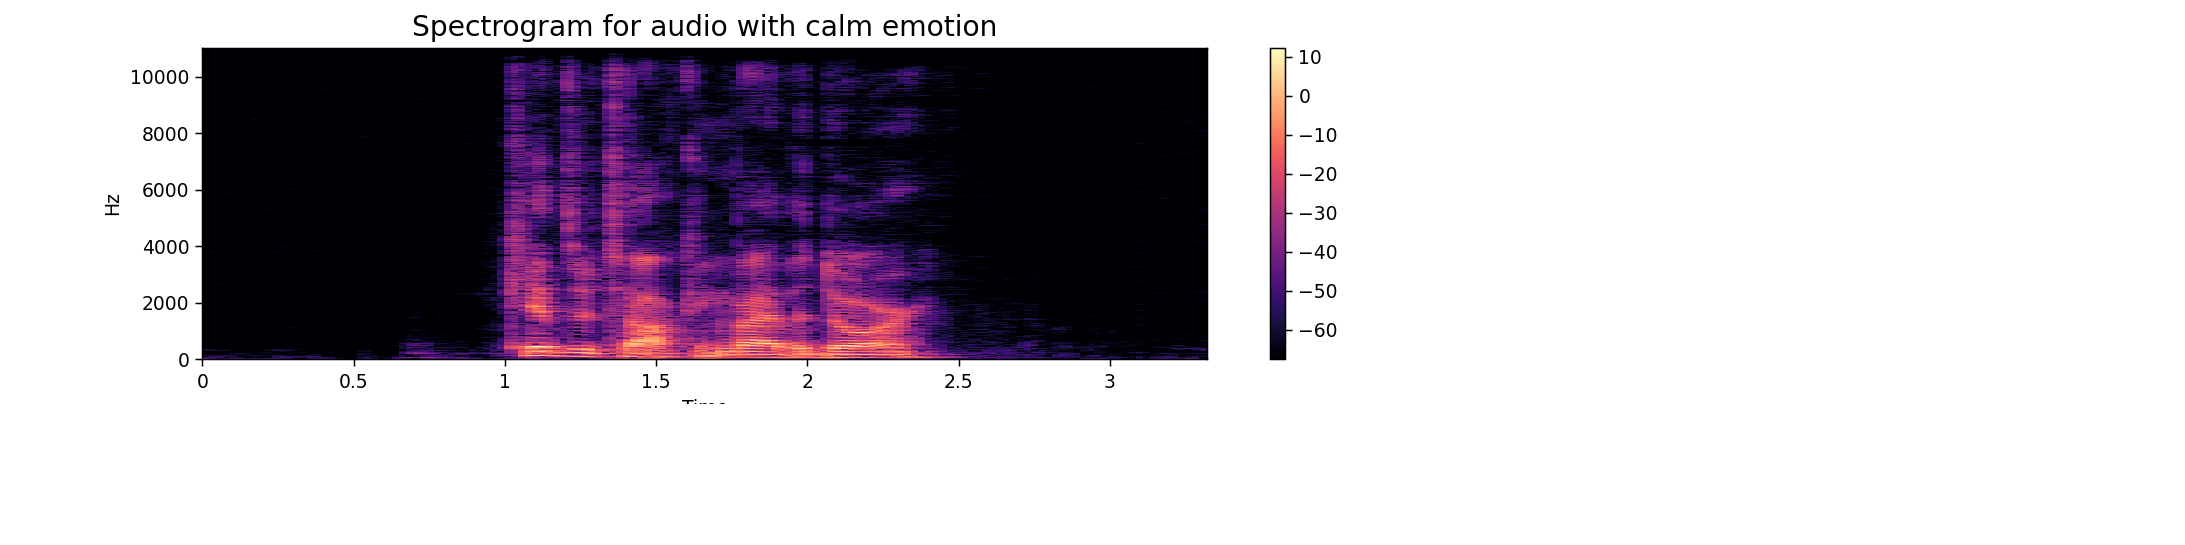

<IPython.core.display.Javascript object>


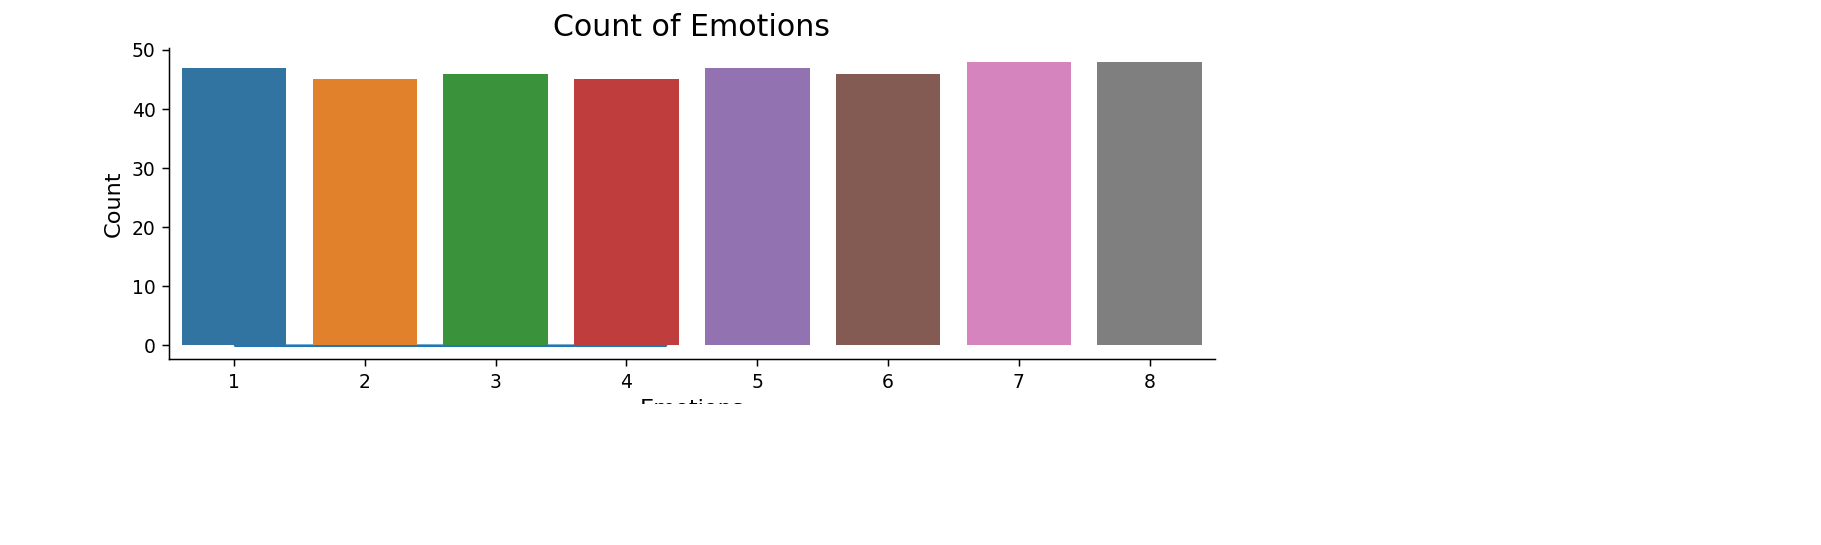

In [4]:
emotion=2
path = np.array(data_path.Path[data_path.Emotions==emotion])[22]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, "calm")
create_waveplot(data, sampling_rate, "calm")
Audio(path)

In [7]:
# Count of Emotions in each class
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


### Functions for adding data 

In [8]:
# Function to add white noise,to stretch the sound,to increase speed and pitch
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

### Data -  Feature Extraction

In [9]:
def extract_features(data,sample_rate):
    result = np.array([])  
    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))     
    return result

In [10]:
X, Y, G = [], [], []

TooShort = 0

for path, emotion,Gender in zip(data_path.Path, data_path.Emotions,data_path.Gender):  # Each Record

    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    data = ((data-np.amin(data))*2)/(np.amax(data) - np.amin(data)) - 1
  
    # Generate 3 types of Records:  data , noise_data, data_stretch_pitch
    noise_data = noise(data)
    stretch_data = stretch(data)
    data_pitch = speedNpitch(data)
   
    Data = [data,noise_data,stretch_data,data_pitch]

    for different_data in Data:          
        # Read training data and split into frames
        frames = []
        frame_len = 22050 # equivalent of 1 seconds
        start = 0
        end = frame_len
        X_Feature = []   
        
         #  Divide audio into frames
        for j in range(0, len(different_data), int(frame_len*0.5)) :
            frame = different_data[j:j+int(frame_len)]
            if len(frame) < frame_len :
                frame = frame.tolist() + [0]* (int(frame_len)-len(frame))
            frame = np.array(frame)

            feature =  extract_features(frame,sample_rate)
            X_Feature.append(feature)
                                
        X_Feature_check = np.array(X_Feature)
        
        # Set the data in the same size
        if X_Feature_check.shape != (5, 128) :
            r,c = X_Feature_check.shape
            if r < 5:
                TooShort = 1
            else:
                TooShort = 0
                X_Feature = X_Feature_check[0:5]
                
        if  TooShort == 0:
            X.append(X_Feature)
            Y.append(emotion)
            G.append(Gender)
len(X)

1488

### Data Preprocessing - Female male balance

In [ ]:
inx_female = [a for a in range(len(G)) if G[a] == 'female']
inx_male = [a for a in range(len(G)) if G[a] == 'male']

Y_female,Y_male,X_female,X_male = [],[],[],[]
for i in inx_female:
    Y_female.append(Y[i])
    X_female.append(X[i])
for i in inx_male:
    Y_male.append(Y[i])
    X_male.append(X[i])

In [ ]:
len(inx_female),len(inx_male)

In [ ]:
# Convert all data to nd array
Y_female = np.array(Y_female)
Y_male = np.array(Y_male)
X_female = np.array(X_female)
X_male = np.array(X_male)

### Data Preprocessing - Split to train & test

In [ ]:
frames_train_m, frames_test_m, y_frames_train_m, y_frames_test_m = train_test_split(X_male, Y_male, test_size=0.25)
frames_train_f, frames_test_f, y_frames_train_f, y_frames_test_f = train_test_split(X_female, Y_female, test_size=0.25)

In [ ]:
frames_train = np.concatenate((frames_train_m, frames_train_f))
frames_test = np.concatenate((frames_test_m, frames_test_f))
y_frames_train = np.concatenate((y_frames_train_m, y_frames_train_f))
y_frames_test = np.concatenate((y_frames_test_m, y_frames_test_f))

### Data Preprocessing - Standardize the data

In [ ]:
mu = frames_train.mean()
std = frames_train.std()
frames_train = (frames_train-mu)/std
frames_test = (frames_test-mu)/std

print("Training samples : ", frames_train.shape, len(y_frames_train), np.unique(y_frames_train, return_counts= True))
print("Testing samples : ", frames_test.shape, len(y_frames_test), np.unique(y_frames_test, return_counts= True))

### Data Preprocessing - Classes balance

In [ ]:
u, f = np.unique(y_frames_train, return_counts= True)
f

In [ ]:
frames_train1 = []
y_frames_train1 = []
maximum = max(f)
count = 0
for i in u :
    ind, = np.where(y_frames_train == i)
    ind = ind.tolist()
    
    while len(ind) < maximum :
        ind = ind + ind
    ind = ind[:maximum]
    temp = frames_train[ind]
    if count == 0 :
        frames_train1 = temp
        count += 1
    else :
        frames_train1 = np.concatenate((frames_train1, temp), axis= 0)

    y_frames_train1 += [i] * maximum

y_frames_train1 = np.array(y_frames_train1)

In [ ]:
print(frames_train1.shape, frames_test.shape, y_frames_train1.shape, y_frames_test.shape) 

In [ ]:
num_features = 5 * 128
x_train = np.reshape(frames_train1, (frames_train1.shape[0], num_features))
x_test = np.reshape(frames_test, (frames_test.shape[0], num_features))
y_train = y_frames_train1
y_test = y_frames_test

# Siamese-networks

### Functions for preparation the input data to siamese model

In [ ]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, num_features))
    x_positives = np.zeros((batch_size, num_features))
    x_negatives = np.zeros((batch_size, num_features))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchSiameseor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

In [ ]:
def data_generator(batch_size):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))   
        yield x, y

## Embedding Model

In [ ]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(emb_size, activation='relu', input_shape=(num_features,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid') # sigmoid(x) = 1 / (1 + exp(-x))
])

embedding_model.summary()

In [ ]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]
print(example_emb)

## Siamese Network

In [ ]:
input_anchor = tf.keras.layers.Input(shape=(num_features,))
input_positive = tf.keras.layers.Input(shape=(num_features,))
input_negative = tf.keras.layers.Input(shape=(num_features,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

## Visualizing the embedding space

In [ ]:
class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(12,8))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False): # Run times as epochs num
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        
        self.ax1.clear()        
        self.values = self.y_test
        self.colors = ListedColormap(['red', 'blue', 'purple','green','black','yellow','magenta','cyan'])
        self.classes = ['Neutral', 'Calm','Happy', 'Sad','Angry', 'Fear','Disgust','Surprise']
        s = self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap=self.colors)
        self.ax1.legend(handles=s.legend_elements()[0], labels=self.classes, loc= "best")
       
        if plot_loss:
            self.ax2.clear()

            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        print("Starting training")
        
    
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)    

## Triplet loss

In [ ]:
alpha = 0.2 # By alpha i know how much the expression: (positive_dist - negative_dist) decreses the loss, 
# if (positive_dist - negative_dist) = - 0.2 this is amazing -> 0 loss

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.) 

## Training & testing the model

In [ ]:
# Properties of the Siamese Network
batch_size = 10
epochs = 300
steps_per_epoch = int(x_train.shape[0]/batch_size)

# Train the Siamese Network
net.compile(loss=triplet_loss, optimizer='adam')

model_history = net.fit(
    
    #Create Train Data
    data_generator(batch_size),
  
    # Prop
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=False,
    
    # Test Data
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test, y_test
        )]
)

## Conclusions

1. There is a relatively good separation between the classes.
2. There are several recordings of "calmness" that are in the space of "sadness" logically.
3. "Neutral" has a cluster that spans a lot of space.
4. The loss value reaches to minimum as early as 200 epochs.

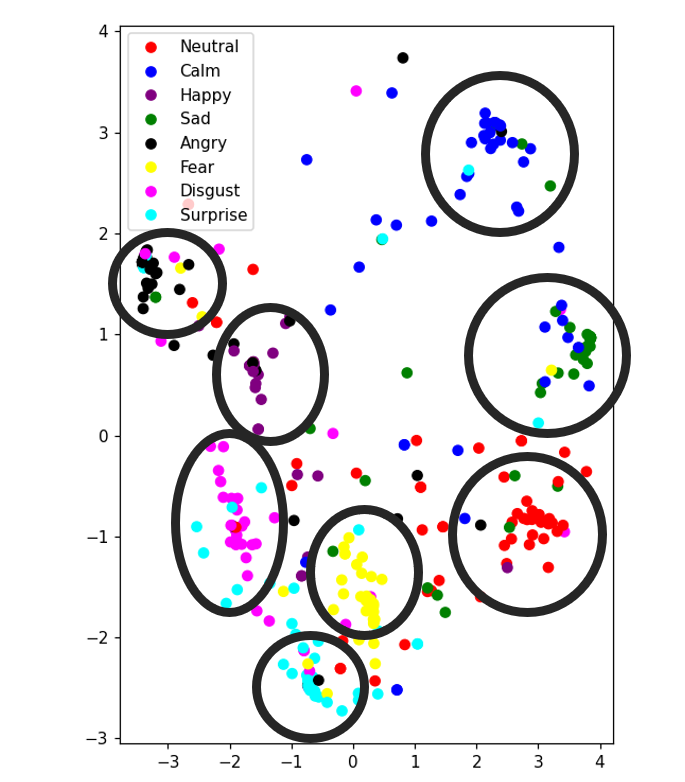

## Improvement
Data:
1. Adding features such as RMS, zero-crossing rate, etc.
2. Reduce unnecessary silence.

NN:
1. To change and to add layers.
2. Hyperparameter.


## References
1. https://towardsdatascience.com/bird-song-classification-using-siamese-networks-and-dilated-convolutions-3b38a115bc1 
2. https://www.geeksforgeeks.org/intuition-of-adam-optimizer/
3. https://github.com/mkosaka1/Speech_Emotion_Recognition
4. https://www.featureform.com/post/the-definitive-guide-to-embeddings
5. https://wandb.ai/ayush-thakur/dl-question-bank/reports/ReLU-vs-Sigmoid-Function-in-Deep-Neural-Networks--VmlldzoyMDk0MzI
